In [11]:
import torch
from torch import nn
from torch import optim
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms

from sklearn.model_selection import train_test_split

device = "cuda" if torch.cuda.is_available() else "cpu"

### This is the section with variables to change when running different models

# Import your model here after adding it to image_models.py 
from image_models import Basic_CNN
model = Basic_CNN(3,10).to(device)

# for data loader:
dl_batch_size = 32 # sort of hardware specifc
dl_num_cores = 4 # hardware specific, change this to the number of cores on your cpu

# Do we want to normalize the dataset based off of the per-pixel average and stdev?
Do_Image_Normalization = True

# image file paths
image_dir = '2750'

# Training parameters
num_epochs=12
learnrate = 0.001
save_interval = 1
saved_model_states = "Basic_CNN"

### End of modifiable variables

transform = transforms.ToTensor()

if Do_Image_Normalization:
    full_dataset = ImageFolder(root=image_dir, transform=transforms.ToTensor())
    #set up normalization from loader on all data
    from image_normalization import get_mean_stdev

    # Create DataLoader for normalization
    full_dataloader = DataLoader(
        full_dataset,
        batch_size=dl_batch_size,
        shuffle=True,  # Shuffle for training
        num_workers=dl_num_cores,  # Parallel data loading (adjust based on CPU cores)
        pin_memory=True  # Faster data transfer to GPU (if using GPU)
    )

    mean, stdev = get_mean_stdev(full_dataloader)
    print(f'mean: {mean}, stdev: {stdev}')

    transform = transforms.Compose(
        [transforms.Resize((64, 64)), # resize the images to ensure 64x64 pixels
        transforms.ToTensor(), #convert to a tensor
        transforms.Normalize(mean=mean, std=stdev)])

full_dataset = ImageFolder(root=image_dir, transform=transform)

import numpy as np
# Get all indices and their corresponding labels
indices = list(range(len(full_dataset)))
labels = np.array(full_dataset.targets)  # ImageFolder stores class labels here
class_names = full_dataset.classes

print(full_dataset.classes)
print(indices[0],indices[9000])
print(labels[0],labels[9000])

# Stratified split: 80% train, 10% val, 10% test
train_idx, temp_idx = train_test_split(
    indices,
    test_size=0.2,
    stratify=labels,
    random_state=42  # for reproducibility
)
temp_labels = labels[temp_idx]

val_idx, test_idx = train_test_split(temp_idx, 
                                     test_size = 0.5, 
                                     stratify = temp_labels, 
                                     random_state = 42)

# create subsets
train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)
test_dataset = Subset(full_dataset, test_idx)

mean: tensor([0.3444, 0.3803, 0.4078]), stdev: tensor([0.2037, 0.1366, 0.1148])
['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
0 9000
0 3


In [12]:
test_loader = DataLoader(
    test_dataset,
    batch_size=dl_batch_size,
    shuffle=True,  # Shuffle for training
    num_workers=dl_num_cores,  # Parallel data loading (adjust based on CPU cores)
    pin_memory=True  # Faster data transfer to GPU (if using GPU)
)

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

from image_models import Deepest_CNN
model = Deepest_CNN(3,10).to(device)
model.load_state_dict(torch.load("Trained_40epoch_Deepest.pth", weights_only=True))
model.eval()

Deepest_CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

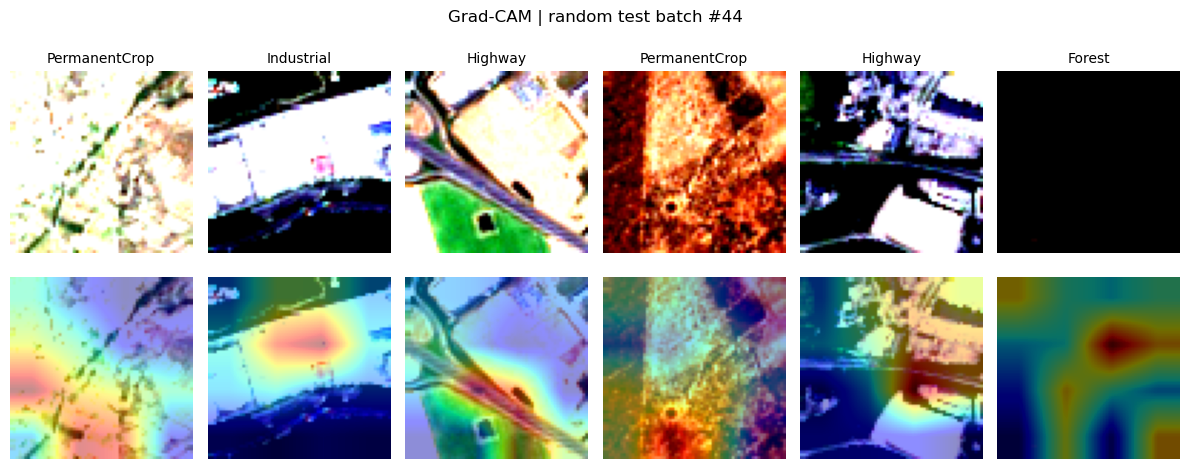

In [19]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

model.eval()
def get_class_names(dset):
    if hasattr(dset, "classes"):
        return dset.classes
    elif hasattr(dset, "dataset"):
        return get_class_names(dset.dataset)
    else:
        return None

classes = get_class_names(test_loader.dataset)
if classes is None:
    classes = [str(i) for i in range(10)]
idx_to_class = {i: c for i, c in enumerate(classes)}

rand_idx = random.randint(0, len(test_loader) - 1)
xb = yb = None
for b_idx, (xb_tmp, yb_tmp) in enumerate(test_loader):
    if b_idx == rand_idx:
        xb, yb = xb_tmp.to(device), yb_tmp.to(device)
        break
assert xb is not None, "Failed to fetch a random batch."

features = []
def hook_fn(m, i, o):
    features.append(o.detach())
hook = model.bn4.register_forward_hook(hook_fn)

with torch.no_grad():
    logits = model(xb)
pred_idx = logits.argmax(dim=1)

A_pre = features.pop()
hook.remove()

A = model.pool(A_pre)
W = model.fc1.weight.detach()

n_show = min(6, xb.size(0))
fig, axes = plt.subplots(2, n_show, figsize=(12, 5))

C, Hf, Wf = A.size(1), A.size(2), A.size(3)

for i in range(n_show):
    pred_cls = int(pred_idx[i])
    Wc = W[pred_cls].view(C, Hf, Wf)
    cam = (Wc * A[i]).sum(dim=0)
    cam = F.relu(cam)
    cam = (cam - cam.min()) / (cam.max() + 1e-8)
    cam_up = F.interpolate(cam[None, None], size=(64, 64), mode='bilinear', align_corners=False)[0, 0]

    img = xb[i].detach().permute(1, 2, 0).cpu().tolist()

    cls_name = idx_to_class.get(int(yb[i]), str(int(yb[i])))  
    axes[0, i].imshow(img)
    axes[0, i].set_title(cls_name, fontsize=10)
    axes[0, i].axis("off")

    axes[1, i].imshow(img)
    axes[1, i].imshow(cam_up.cpu().tolist(), alpha=0.45, cmap="jet")
    axes[1, i].axis("off")

plt.suptitle(f"Grad-CAM | random test batch #{rand_idx}")
plt.tight_layout()
plt.show()


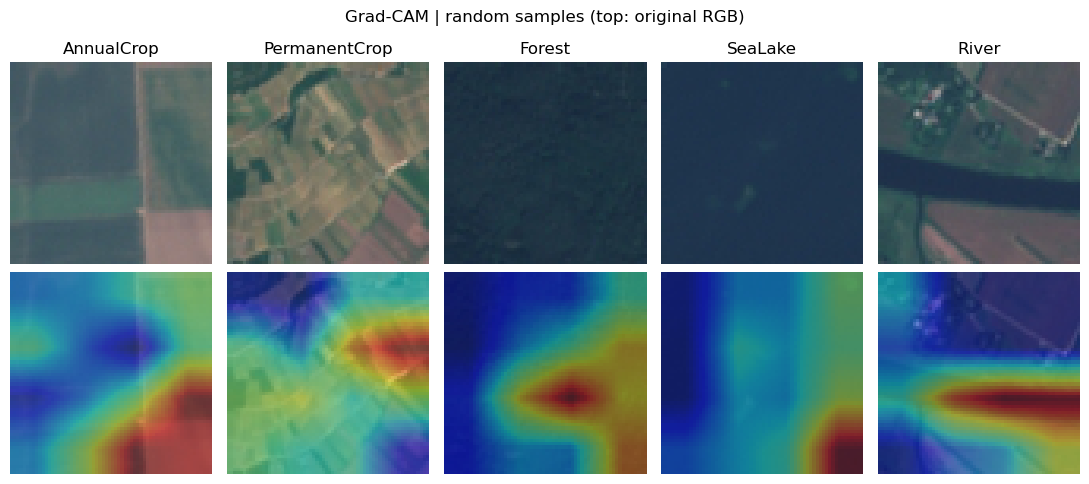

In [50]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import functional as TF

model.eval()

def get_classes(dset):
    if hasattr(dset, "classes"):
        return dset.classes
    if hasattr(dset, "dataset"):
        return get_classes(dset.dataset)
    return None

def resolve_base_and_index(dset, idx):
    cur, cur_idx = dset, idx
    while hasattr(cur, "dataset"):
        if hasattr(cur, "indices"):
            cur_idx = cur.indices[cur_idx]
        cur = cur.dataset
    return cur, cur_idx

def path_for_index(dset, idx):
    base, base_idx = resolve_base_and_index(dset, idx)
    if hasattr(base, "samples"):
        return base.samples[base_idx][0]
    if hasattr(base, "imgs"):
        return base.imgs[base_idx][0]
    return None

ds = test_loader.dataset
classes = get_classes(ds) or [str(i) for i in range(1000)]
idx_to_class = {i: c for i, c in enumerate(classes)}

n_show = 5
all_idx = list(range(len(ds)))
random.shuffle(all_idx)
pick_idx = all_idx[:n_show]

xs, ys, paths = [], [], []
for idx in pick_idx:
    x, y = ds[idx][0], int(ds[idx][1])
    p = path_for_index(ds, idx)
    xs.append(x.unsqueeze(0))
    ys.append(y)
    paths.append(p)

xb = torch.cat(xs, dim=0).to(device)
yb = torch.tensor(ys, device=device)
B, C, H_img, W_img = xb.shape  

features = []
def hook_fn(m, i, o):
    features.append(o.detach())
hook = model.bn4.register_forward_hook(hook_fn)

with torch.no_grad():
    logits = model(xb)
pred_idx = logits.argmax(dim=1)

A_pre = features.pop()
hook.remove()

A = model.pool(A_pre)                       # [B,C,Hf,Wf]
W_fc = model.fc1.weight.detach()            
C2, Hf, Wf = A.size(1), A.size(2), A.size(3)

fig, axes = plt.subplots(2, B, figsize=(2.2*B, 5))

for i in range(B):
    cls_pred = int(pred_idx[i])
    Wc = W_fc[cls_pred].view(C2, Hf, Wf)
    cam = (Wc * A[i]).sum(dim=0)
    cam = F.relu(cam)
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
    cam_up = F.interpolate(
        cam[None, None],
        size=(int(H_img), int(W_img)),
        mode="bilinear",
        align_corners=False
    )[0, 0].cpu().tolist()

    if paths[i] is not None:
        pil = Image.open(paths[i]).convert("RGB").resize(
            (int(W_img), int(H_img)), Image.BILINEAR
        )
        img_rgb = TF.pil_to_tensor(pil).float().div(255.0).permute(1, 2, 0).tolist()
    else:
        x_cpu = xb[i].detach().cpu()
        x_cpu = (x_cpu - x_cpu.min()) / (x_cpu.max() - x_cpu.min() + 1e-8)
        img_rgb = x_cpu.permute(1, 2, 0).tolist()

    title = idx_to_class.get(int(yb[i]), str(int(yb[i])))
    axes[0, i].imshow(img_rgb); axes[0, i].set_title(title); axes[0, i].axis("off")
    axes[1, i].imshow(img_rgb); axes[1, i].imshow(cam_up, alpha=0.45, cmap="jet"); axes[1, i].axis("off")

plt.suptitle("Grad-CAM | random samples (top: original RGB)")
plt.tight_layout()
plt.show()
